# Face Recognition

## 0. Importar librerías

In [101]:
#!pip install tensorflow==2.3.0

In [168]:
# import tensorflow as tf
# print(tf.__version__)

In [169]:
# !python --version

In [170]:
# print(keras.__version__)

In [156]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
from tensorflow.keras.models import model_from_json
from tensorflow import keras
import numpy as np
from numpy import genfromtxt
import pandas as pd
import PIL

#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [108]:
# from keras.src.saving import serialization_lib
# serialization_lib.enable_unsafe_deserialization()

In [157]:
# Load the model architecture from the JSON file
json_file_path = './keras-facenet-h5/model.json'
with open(json_file_path, 'r') as json_file:
    model_json = json_file.read()

# Recreate the model from the JSON file
model = model_from_json(model_json)

# Load the weights into the model
weights_file_path = './keras-facenet-h5/model.h5'
model.load_weights(weights_file_path)

# Compile the model if required
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now the model is loaded and ready to use

In [111]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_6:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm_6/add_1:0' shape=(None, 128) dtype=float32>]


In [171]:
# UNQ_C1(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Compute the (encoding) distance between the anchor and the positive
    pos_dist =  tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

## Cargamos el modelo pre-entrenado

In [113]:
FRmodel = model

## Aplicando el modelo

In [126]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [127]:
database = {}
database["Estephania"] = img_to_encoding("images/Estephania.jpeg", FRmodel)
database["Vesna"] = img_to_encoding("images/Vesna.jpeg", FRmodel)
database["Leonela"] = img_to_encoding("images/Leonela.jpeg", FRmodel)

Cargamos las imágenes de Estephania y Leonela:

In [128]:
estephania = tf.keras.preprocessing.image.load_img("images/Estephania.jpeg", target_size=(160, 160))
leonela = tf.keras.preprocessing.image.load_img("images/Leonela.jpeg", target_size=(160, 160))

In [129]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

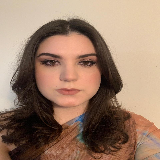

In [131]:
estephania

In [119]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

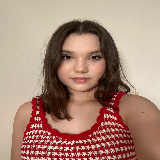

In [132]:
leonela

In [158]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".

    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras

    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    ### START CODE HERE
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding =  img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist<0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    ### END CODE HERE
    return dist, door_open

In [172]:
### YOU CANNOT EDIT THIS CELL

verify("images/imagen2.jpeg", "Estephania", database, FRmodel)

It's not Estephania, please go away


(1.0675745, False)

In [173]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.

    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras

    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """

    ## Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding =   img_to_encoding(image_path, model)

    ## Find the closest encoding ##

    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100

    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():

        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist =  np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist<min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity